In [ ]:
!unzip  /content/test.zip -d extracted_folder

Archive:  /content/test.zip
   creating: extracted_folder/test/
   creating: extracted_folder/test/train/
   creating: extracted_folder/test/train/rough/
  inflating: extracted_folder/test/train/rough/smooth_0_1008.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1048.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_106.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_108.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1090.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1101.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1103.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1107.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1119.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_114.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1140.jpeg  
  inflating: extracted_folder/test/train/rough/smooth_0_1162.jpeg  
  inflating: extracted_folder/tes

In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/extracted_folder/test/train',
    target_size=(224, 224),  # Change based on model input size
    batch_size=32,
    class_mode='binary',  # 'binary' since we have two classes
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/extracted_folder/test/validate',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 750 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
import kagglehub
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd

path = '/content/extracted_folder/test'
file_names = []
labels = []

supported_extensions = ('.jpg', '.jpeg', '.png')

for file in tqdm(sorted(Path(path).rglob('*/*/*'))):
    if file.suffix.lower() in supported_extensions:
        file_names.append(str(file))
        label = file.parent.name
        labels.append(label)

print(f"Total images: {len(file_names)}, Total labels: {len(labels)}, Unique labels: {len(set(labels))}")

if len(file_names) != len(labels):
    print("Warning: The number of images does not match the number of labels!")

df = pd.DataFrame({"image": file_names, "label": labels})
print(df.head())

df.to_csv("skin_types_dataset.csv", index=False)
print("Dataframe saved to 'skin_types_dataset.csv'")


100%|██████████| 1093/1093 [00:00<00:00, 188509.98it/s]

Total images: 1093, Total labels: 1093, Unique labels: 2
                                               image  label
0  /content/extracted_folder/test/train/rough/smo...  rough
1  /content/extracted_folder/test/train/rough/smo...  rough
2  /content/extracted_folder/test/train/rough/smo...  rough
3  /content/extracted_folder/test/train/rough/smo...  rough
4  /content/extracted_folder/test/train/rough/smo...  rough
Dataframe saved to 'skin_types_dataset.csv'


In [ ]:
df['label'].count()
df['image'].count()


1093

In [ ]:
df.head()

,image,label
0,/content/extracted_folder/test/train/rough/smo...,rough
1,/content/extracted_folder/test/train/rough/smo...,rough
2,/content/extracted_folder/test/train/rough/smo...,rough
3,/content/extracted_folder/test/train/rough/smo...,rough
4,/content/extracted_folder/test/train/rough/smo...,rough


In [ ]:
df['label'].unique()

array(['rough', 'smooth'], dtype=object)

In [ ]:
df['label'].value_counts().head()

,count
label,
rough,614
smooth,479


In [ ]:

from imblearn.over_sampling import RandomOverSampler
import gc
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(1228, 2)


In [ ]:
df['label'].value_counts().head()

,count
label,
rough,614
smooth,614


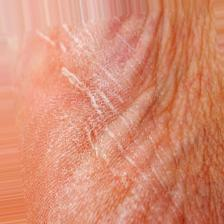

In [ ]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset[0]['image']

In [ ]:
labels_subset = list(df['label'])[:5]
print(labels_subset)

['rough', 'rough', 'rough', 'rough', 'rough']


In [ ]:
labels_list = sorted(list(set(df['label'])))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label


print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'rough', 1: 'smooth'} 

Mapping of Labels to IDs: {'rough': 0, 'smooth': 1}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/1228 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1228 [00:00<?, ? examples/s]

In [ ]:

model_str = "dima806/skin_types_image_detection"

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)
normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        RandomHorizontalFlip(0.5),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained model with mismatched sizes allowed
model = ViTForImageClassification.from_pretrained(
    model_str,
    num_labels=len(labels_list),  # Ensure this matches the new task's labels
    ignore_mismatched_sizes=True  # This allows the model to load with a different classifier size
)

# Update the model's configuration for label mapping
model.config.id2label = id2label
model.config.label2id = label2id

# Print the number of trainable parameters
print(f"Trainable parameters: {model.num_parameters(only_trainable=True) / 1e6:.2f}M")


config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at dima806/skin_types_image_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 85.80M


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)

    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"

model_name = "Texture_Classification"

num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=5e-7,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
   load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6642580628395081,
 'eval_model_preparation_time': 0.007,
 'eval_accuracy': 0.6300813008130082,
 'eval_runtime': 8.285,
 'eval_samples_per_second': 59.384,
 'eval_steps_per_second': 1.931}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.663726,0.007000,0.640244
2,No log,0.662034,0.007000,0.648374
3,No log,0.659171,0.007000,0.658537
4,No log,0.655242,0.007000,0.686992
5,No log,0.652198,0.007000,0.703252


TrainOutput(global_step=60, training_loss=0.6553138097127279, metrics={'train_runtime': 191.2547, 'train_samples_per_second': 19.241, 'train_steps_per_second': 0.314, 'total_flos': 2.8517052178169856e+17, 'train_loss': 0.6553138097127279, 'epoch': 5.0})

In [ ]:
outputs = trainer.predict(test_data)

In [ ]:
outputs.metrics

{'test_loss': 0.6910034418106079,
 'test_model_preparation_time': 0.0042,
 'test_accuracy': 0.5304878048780488,
 'test_runtime': 5.8116,
 'test_samples_per_second': 84.658,
 'test_steps_per_second': 2.753}

Accuracy: 0.5305
F1 Score: 0.5107


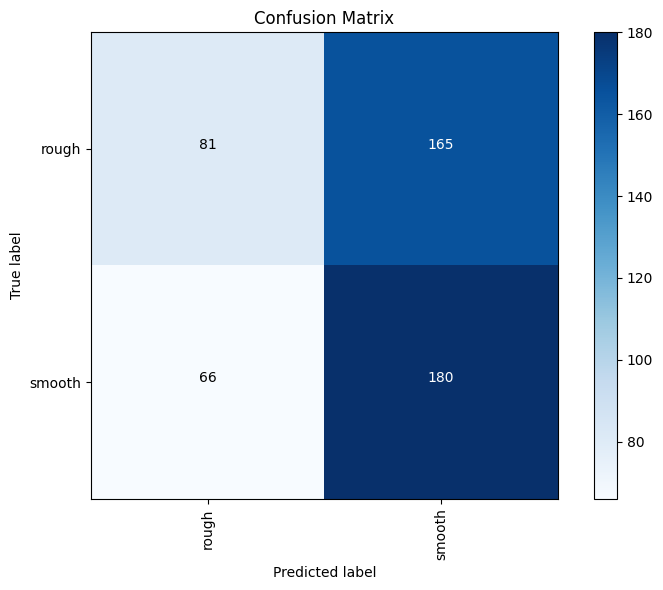


Classification report:

              precision    recall  f1-score   support

       rough     0.5510    0.3293    0.4122       246
      smooth     0.5217    0.7317    0.6091       246

    accuracy                         0.5305       492
   macro avg     0.5364    0.5305    0.5107       492
weighted avg     0.5364    0.5305    0.5107       492



In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 250:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
try:
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
except:
    pass

In [ ]:
from datasets import concatenate_datasets

# Combine all splits into one dataset
if isinstance(dataset, dict):
    full_dataset = concatenate_datasets([dataset['train'], dataset['test']])
else:
    full_dataset = dataset

# Convert the full dataset to a DataFrame
df = pd.DataFrame(full_dataset)

# Extract labels from the combined dataset
labels = df['label'].values


In [ ]:
trainer.save_model()

In [ ]:
# Assuming 'file_names' originally contained the file paths
df['image'] = file_names


In [ ]:
from PIL import Image

def train_transforms(examples):
    # Load images from file paths and apply transformations
    examples['pixel_values'] = [
        _train_transforms(Image.open(image_path).convert("RGB"))
        for image_path in examples['image']
    ]
    return examples

def val_transforms(examples):
    # Load images from file paths and apply transformations
    examples['pixel_values'] = [
        _val_transforms(Image.open(image_path).convert("RGB"))
        for image_path in examples['image']
    ]
    return examples


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Parameters for cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
metric_name = "eval_accuracy"  # Use the correct metric key

for fold, (train_idx, val_idx) in enumerate(skf.split(df, labels)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    # Split the data into training and validation
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    # Ensure the `image` column exists and contains file paths
    train_df["image"] = train_df["image"].astype(str)
    val_df["image"] = val_df["image"].astype(str)

    # Map labels to integers
    train_df["label"] = train_df["label"].map(label2id)
    val_df["label"] = val_df["label"].map(label2id)

    # Convert to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    # Apply transformations
    train_dataset.set_transform(train_transforms)
    val_dataset.set_transform(val_transforms)

    # Debugging: Check datasets
    print(f"Sample from train dataset: {train_dataset[0]}")
    print(f"Sample from val dataset: {val_dataset[0]}")

    # Define Trainer
    fold_trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    fold_trainer.train()
    eval_results = fold_trainer.evaluate()

    # Debugging: Log all evaluation results
    print(f"Evaluation results for fold {fold + 1}: {eval_results}")

    # Record accuracy
    if metric_name in eval_results:
        fold_accuracy = eval_results[metric_name]
        fold_accuracies.append(fold_accuracy)
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")
    else:
        print(f"Metric '{metric_name}' missing in fold {fold + 1} results. Available keys: {eval_results.keys()}")
        raise KeyError(f"Metric '{metric_name}' not found in evaluation results.")

# Final Cross-Validation Results
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"\nCross-Validation Results:\nMean Accuracy: {mean_accuracy:.4f}\nStd Dev: {std_accuracy:.4f}")



--- Fold 1/5 ---
Sample from train dataset: {'image': '/content/extracted_folder/test/train/rough/smooth_0_1008.jpeg', 'label': 0, '__index_level_0__': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ...,

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.644582,0.739726
2,No log,0.642256,0.748858
3,No log,0.638363,0.753425
4,No log,0.633153,0.762557
5,No log,0.630971,0.762557


Evaluation results for fold 1: {'eval_loss': 0.6309710741043091, 'eval_accuracy': 0.7625570776255708, 'eval_runtime': 2.6133, 'eval_samples_per_second': 83.801, 'eval_steps_per_second': 2.679, 'epoch': 5.0}
Fold 1 Accuracy: 0.7626

--- Fold 2/5 ---
Sample from train dataset: {'image': '/content/extracted_folder/test/train/rough/smooth_0_1008.jpeg', 'label': 0, '__index_level_0__': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.636903,0.744292
2,No log,0.634604,0.748858
3,No log,0.630731,0.757991
4,No log,0.625556,0.762557
5,No log,0.623424,0.762557


Evaluation results for fold 2: {'eval_loss': 0.6234237551689148, 'eval_accuracy': 0.7625570776255708, 'eval_runtime': 2.6767, 'eval_samples_per_second': 81.818, 'eval_steps_per_second': 2.615, 'epoch': 5.0}
Fold 2 Accuracy: 0.7626

--- Fold 3/5 ---
Sample from train dataset: {'image': '/content/extracted_folder/test/train/rough/smooth_0_1048.jpeg', 'label': 0, '__index_level_0__': 1, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.613039,0.785388
2,No log,0.610386,0.785388
3,No log,0.605918,0.794521
4,No log,0.600038,0.799087
5,No log,0.597576,0.803653


Evaluation results for fold 3: {'eval_loss': 0.5975762605667114, 'eval_accuracy': 0.8036529680365296, 'eval_runtime': 2.6053, 'eval_samples_per_second': 84.06, 'eval_steps_per_second': 2.687, 'epoch': 5.0}
Fold 3 Accuracy: 0.8037

--- Fold 4/5 ---
Sample from train dataset: {'image': '/content/extracted_folder/test/train/rough/smooth_0_1008.jpeg', 'label': 0, '__index_level_0__': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

  

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.602866,0.834862
2,No log,0.600211,0.834862
3,No log,0.595639,0.844037
4,No log,0.589630,0.857798
5,No log,0.587067,0.862385


Evaluation results for fold 4: {'eval_loss': 0.587066650390625, 'eval_accuracy': 0.8623853211009175, 'eval_runtime': 2.8188, 'eval_samples_per_second': 77.339, 'eval_steps_per_second': 2.483, 'epoch': 5.0}
Fold 4 Accuracy: 0.8624

--- Fold 5/5 ---
Sample from train dataset: {'image': '/content/extracted_folder/test/train/rough/smooth_0_1008.jpeg', 'label': 0, '__index_level_0__': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

  

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.576798,0.862385
2,No log,0.574001,0.862385
3,No log,0.569136,0.885321
4,No log,0.562739,0.894495
5,No log,0.560059,0.899083


Evaluation results for fold 5: {'eval_loss': 0.5600588321685791, 'eval_accuracy': 0.8990825688073395, 'eval_runtime': 2.6269, 'eval_samples_per_second': 82.989, 'eval_steps_per_second': 2.665, 'epoch': 5.0}
Fold 5 Accuracy: 0.8991

Cross-Validation Results:
Mean Accuracy: 0.8180
Std Dev: 0.0546


In [ ]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)
image =test_data[1]["image"]
pipe(image)

[{'label': 'smooth', 'score': 0.5303134322166443},
 {'label': 'rough', 'score': 0.4994414150714874}]

In [ ]:
import cv2

i = cv2.imread("/content/extracted_folder/test/train/rough/smooth_0_1090.jpeg")

In [ ]:

from PIL import Image
# Convert from OpenCV (BGR) to RGB format
image_rgb = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)

# Convert OpenCV image (NumPy array) to PIL Image
pil_image = Image.fromarray(image_rgb)

# Now pass the PIL image to the function
result = pipe(pil_image)


In [ ]:
result

[{'label': 'rough', 'score': 0.5131726861000061},
 {'label': 'smooth', 'score': 0.48693808913230896}]

In [ ]:


# Generate predictions and true labels for the validation set
# Assuming validation_generator is the generator for your validation set
true_labels = validation_generator.classes  # True labels from the generator
predictions = model.predict(validation_generator)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary labels

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Rough', 'smooth'], yticklabels=['rough', 'smooth'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

AttributeError: 'ViTForImageClassification' object has no attribute 'predict'